<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/introductionVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Méthode de vision par ordinateur "traditionnelles"

## Extraction de contours

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy
import PIL
from PIL import Image
import skimage

def show(x):
    if len(x.shape)==2:
        plt.imshow(x, interpolation='nearest')
        return
    if len(x.shape)==3:
        visu = torch.stack([x[0],x[1],x[2]],dim=-1)
        plt.imshow(visu.numpy(), interpolation='nearest')
    else:
        show(torchvision.utils.make_grid(x))

def readimage(path):
    tmp = PIL.Image.open(path)
    x = torch.Tensor(numpy.asarray(tmp)).clone()
    if len(x.shape)==2:
        return x/255
    else:
        return torch.stack([x[:,:,0],x[:,:,1],x[:,:,2]],dim=0)/255


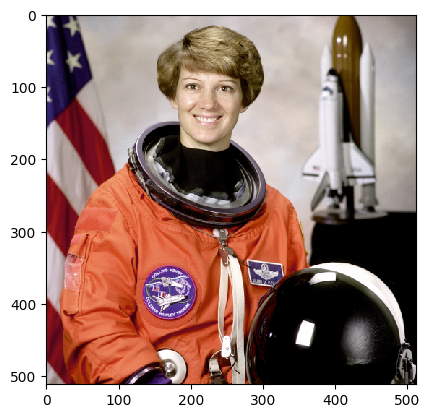

In [2]:
image = skimage.data.astronaut()
image = torch.Tensor(numpy.asarray(image))
image = torch.stack([image[:,:,0],image[:,:,1],image[:,:,2]],dim=0)/255
show(image)

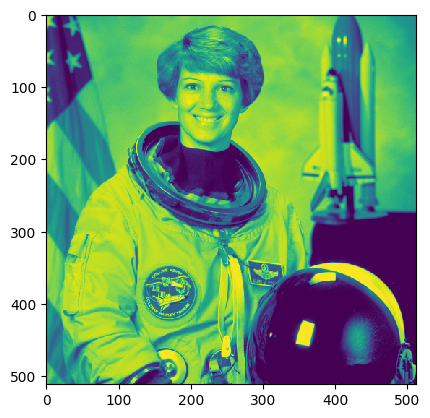

In [3]:
show(image[0])

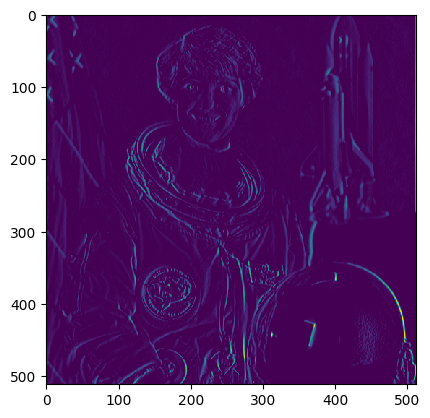

In [4]:
import torch

def sobel_filter1(image):
    sobel_x = torch.tensor([[1, 0, -1],
                           [2, 0, -2],
                           [1, 0, -1]]).view(1,1,3,3).float()
    sobel_y = torch.tensor([[1, 2, 1],
                           [0, 0, 0],
                           [-1, -2, -1]]).view(1,1,3,3).float()
    x = image.unsqueeze(0)
    hori = torch.nn.functional.conv2d(x, sobel_x, padding=1)
    vert = torch.nn.functional.conv2d(x, sobel_y, padding=1)

    horiP = hori*(hori>0).float()/hori.max()
    horiN = hori*(hori<0).float()/hori.min()
    vertP = vert*(vert>0).float()/vert.max()
    vertN = vert*(vert<0).float()/vert.min()

    return horiP[0],horiN[0],vertP[0],vertN[0]

# Example usage
gradients = sobel_filter1(image[0])
show(gradients[0])

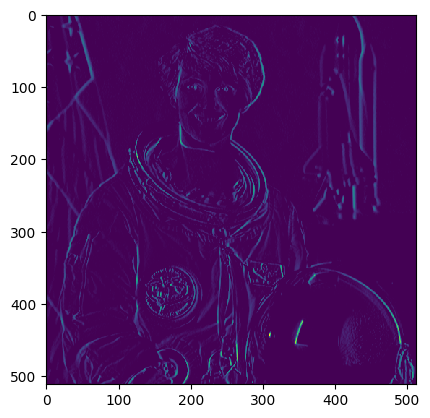

In [5]:
show(gradients[1])

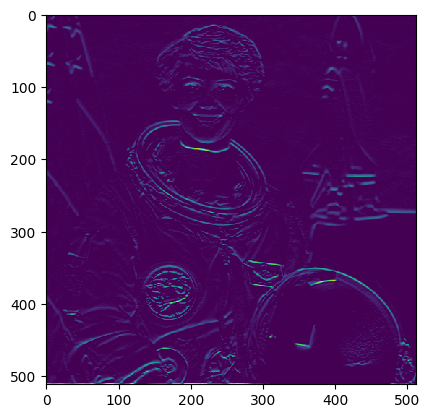

In [6]:
show(gradients[2])

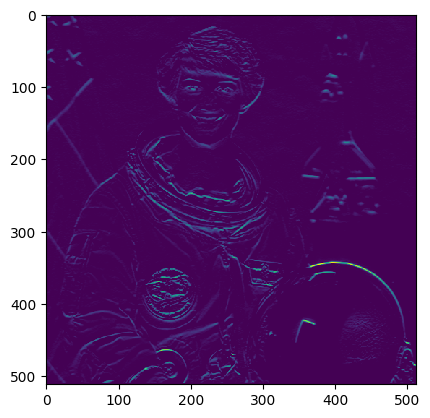

In [7]:
show(gradients[3])

généralement, cette méthode est combinée avec des techniques de double seuillage.

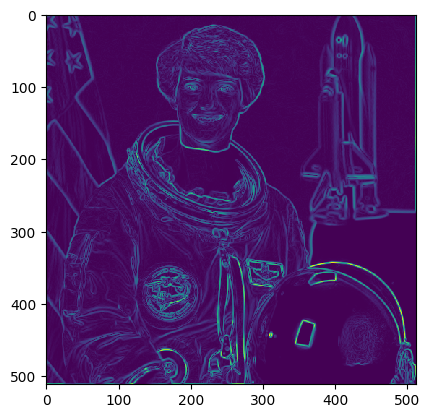

In [8]:
def sobel_filter2(image):
    sobel_x = torch.tensor([[1, 0, -1],
                           [2, 0, -2],
                           [1, 0, -1]]).float()/3
    sobel_y = torch.tensor([[1, 2, 1],
                           [0, 0, 0],
                           [-1, -2, -1]]).float()/3
    sobel_x = torch.stack([sobel_x]*3,dim=0).unsqueeze(0)
    sobel_y = torch.stack([sobel_y]*3,dim=0).unsqueeze(0)
    x = image.unsqueeze(0)
    hori = torch.nn.functional.conv2d(x, sobel_x, padding=1).abs()
    vert = torch.nn.functional.conv2d(x, sobel_y, padding=1).abs()

    grad = torch.max(hori,vert)
    return grad[0][0]

gradIm = sobel_filter2(image)
show(gradIm/gradIm.max())

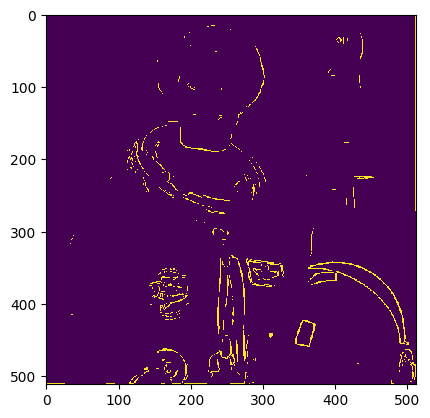

In [9]:
show((gradIm>1.5).float())

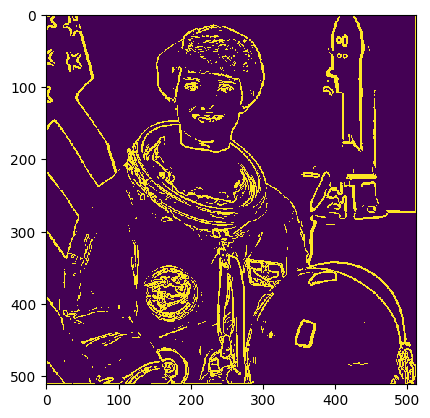

In [10]:
show((gradIm>0.6).float())

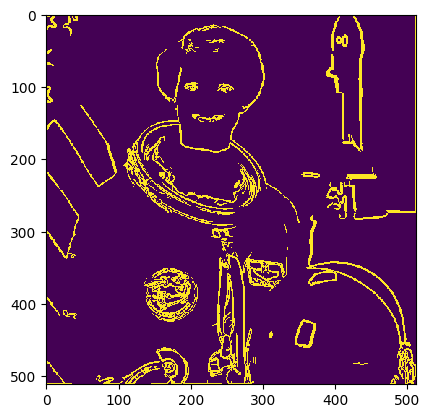

In [11]:
def doubleSeuil(x,seuil_haut=1.5,seuil_bas=0.6):
    xH,xB = (x>seuil_haut).float(),(x>seuil_bas).float()
    xH = xH.view(1,1,x.shape[0],x.shape[1])

    # on garde les pixels de xB quand ils sont connectés à un pixel de xH
    for i in range(100):
        xH = torch.nn.functional.max_pool2d(xH,kernel_size=3,stride=1,padding=1)*xB
    return xH[0][0]

show(doubleSeuil(gradIm))

histogramme of oriented gradient
https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html

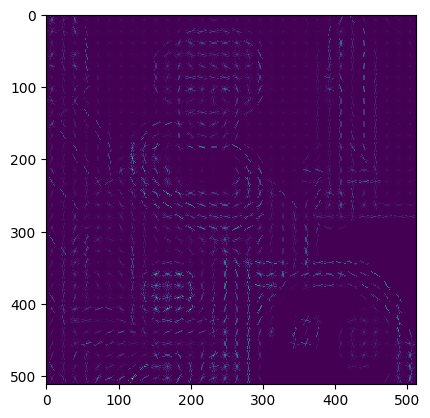

In [12]:
_, hog_image = skimage.feature.hog(skimage.data.astronaut(), orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True, channel_axis=-1)

hog_image = torch.Tensor(numpy.asarray(hog_image)).float().abs()
show(hog_image/hog_image.max())

##Maintenant les points d'intérêts !

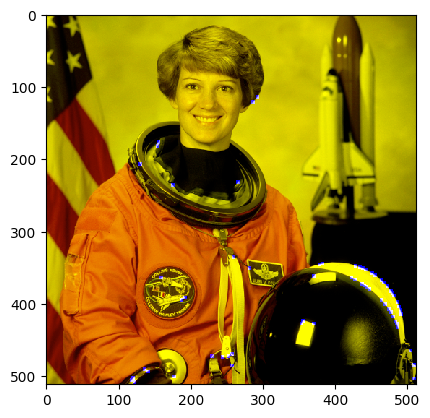

In [13]:
def harris(image):
    sobel_x = torch.tensor([[1, 0, -1],
                           [2, 0, -2],
                           [1, 0, -1]]).float()
    sobel_y = torch.tensor([[1, 2, 1],
                           [0, 0, 0],
                           [-1, -2, -1]]).float()
    sobel_x = torch.stack([sobel_x]*3,dim=0).unsqueeze(0)
    sobel_y = torch.stack([sobel_y]*3,dim=0).unsqueeze(0)
    x = image.unsqueeze(0)
    hori = torch.nn.functional.conv2d(x, sobel_x, padding=1)
    vert = torch.nn.functional.conv2d(x, sobel_y, padding=1)

    _,_,h,w = hori.shape
    hori,vert = hori.flatten(), vert.flatten()
    hori,vert = hori/hori.abs().max(), vert/vert.abs().max()
    H = torch.zeros(hori.shape[0],2,2)
    H[:,0,0] = hori*hori
    H[:,1,1] = vert*vert
    H[:,1,0] = hori*vert
    H[:,0,1] = hori*vert

    H = torch.det(H)
    tmp,_ = H.sort()

    H = H.view(h,w).unsqueeze(0)
    H = 100*H-99*torch.nn.functional.max_pool2d(H,kernel_size=5,stride=1,padding=2)
    return (H>=tmp[-100]).float()

visu = image.clone()
point = harris(image)
visu[2] = torch.nn.functional.max_pool2d(point,kernel_size=5,stride=1,padding=2)[0]
show(visu)

une remarque : de façon assez inattendu, on n'a pas de point sur le drapeau ?!?
(car trop flou, mais ça ne change rien de repartir d'une image plus flou ou d'utiliser un autre algorithme d'extraction de points...)

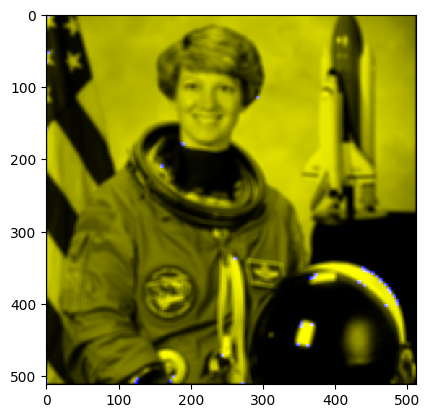

In [14]:
visu = image.clone()
visu = torch.stack([visu[1]]*3,dim=0)
visu = torch.nn.functional.avg_pool2d(visu.unsqueeze(0),kernel_size=7,padding=3,stride=1)[0]
point = harris(visu)
visu[2] = torch.nn.functional.max_pool2d(point,kernel_size=5,stride=1,padding=2)[0]
show(visu)

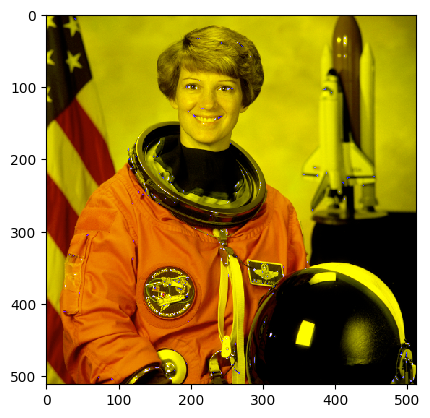

In [15]:
imagetmp = skimage.feature.corner_fast(skimage.color.rgb2gray(skimage.data.astronaut()))
imagetmp = torch.Tensor(numpy.asarray(imagetmp))
imagetmp = imagetmp
visu = image.clone()
visu[2] = imagetmp
show(visu)

matching de points d'intérêt :
https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_brief.html#sphx-glr-auto-examples-features-detection-plot-brief-py

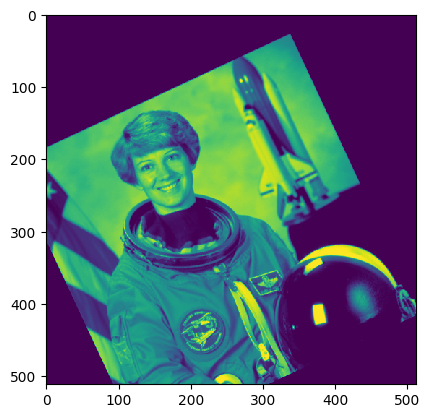

In [16]:
image = skimage.color.rgb2gray(skimage.data.astronaut())

tform = skimage.transform.AffineTransform(scale=(1.2, 1.2), translation=(0, -100))
imagebis = skimage.transform.warp(image, tform)
imagebis = skimage.transform.rotate(imagebis, 25)

imagetmp = torch.Tensor(numpy.asarray(imagebis))
show(imagetmp)

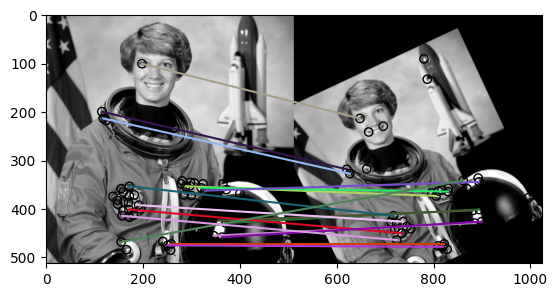

In [17]:

keypoints1 = skimage.feature.corner_peaks(skimage.feature.corner_harris(image), min_distance=5,
                          threshold_rel=0.1)
keypoints2 = skimage.feature.corner_peaks(skimage.feature.corner_harris(imagebis), min_distance=5,
                          threshold_rel=0.1)

extractor = skimage.feature.BRIEF()

extractor.extract(image, keypoints1)
keypoints1 = keypoints1[extractor.mask]
descriptors1 = extractor.descriptors

extractor.extract(imagebis, keypoints2)
keypoints2 = keypoints2[extractor.mask]
descriptors2 = extractor.descriptors

matches = skimage.feature.match_descriptors(descriptors1, descriptors2, cross_check=True)

fig, ax = plt.subplots(nrows=1, ncols=1)
skimage.feature.plot_matches(ax,image, imagebis, keypoints1, keypoints2, matches)
plt.show()

##les méthodes basées vidéos

(example avec https://groups.inf.ed.ac.uk/vision/DATASETS/CAVIAR/CAVIARDATA1/Walk1/Walk1.mpg )